<a href="https://colab.research.google.com/github/sdgroeve/D012554_Machine_Learning_2023/blob/main/02_neural_networks_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Neural networks in PyTorch


In [49]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In this notebook we will analyse a two-class dataset that requires a model that is more complex than the logistic regression model.

We will build and train a neural network for this dataset.

First, we import the required PyTorch libraries and fix the random seed.

In [50]:
import torch
from torch import nn 

torch.manual_seed(46)

# Check PyTorch version
torch.__version__

'1.13.1+cu116'

In [51]:
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

## Preparing the data

The dataset is in a flat file called `dataset_neural_networks.csv`. 

We read this file into a Pandas DataFrame.

In [52]:
import pandas as pd

dataset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/D012554_Machine_Learning_2023/main/datasets/dataset_neural_networks.csv")

dataset.head()

,x_1,x_2,y
0,-0.981663,1.239569,0
1,-0.857931,0.765202,0
2,-1.435887,0.849735,0
3,0.517317,0.993574,1
4,-0.582966,-0.709132,1


The dataset has two features `x_1` and `x_2`, and one label `y`. 

Let's plot this data. 

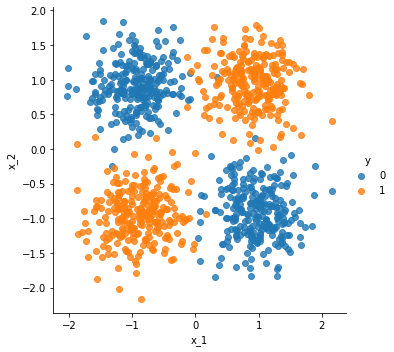

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lmplot(x="x_1",y="x_2",hue="y",data=dataset,fit_reg=False)
plt.show()

We put the feature columns in a DataFrame called `X` and the label column in a DataFrame called `y`.

In [54]:
y = dataset.pop('y')
X = dataset

We create a train, a validation and a test split of the dataset.


In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(800, 2)
(100, 2)
(100, 2)


We create tensors from these splits.

In [56]:
X_train, X_val, X_test = torch.Tensor(X_train.values),torch.Tensor(X_val.values),torch.Tensor(X_test.values)
y_train, y_val, y_test = torch.Tensor(y_train.values),torch.Tensor(y_val.values),torch.Tensor(y_test.values)

## Building the model

To build a neural network architecture we need to set a number of hyperparameter values: 

| **Hyperparameter** | **Description** | 
| --- | --- |
| **Input layer shape** (`in_features`) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) |
| **Hidden layer(s)** | Problem specific, minimum = 1, maximum = unlimited |
| **Neurons per hidden layer** | Problem specific, generally 10 to 512 | 
| **Output layer shape** (`out_features`) | Task specific | 
| **Hidden layer activation** | Usually [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) (rectified linear unit) but [can be many others](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) | 
| **Output activation** | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) ([`torch.sigmoid`](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) in PyTorch)| 
| **Loss function** | [Binary crossentropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) in PyTorch) | 
| **Optimizer** | [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (stochastic gradient descent), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (see [`torch.optim`](https://pytorch.org/docs/stable/optim.html) for more options) | 

We will build a neural network with one hidden layer that hase 6 neurons. 

To do this we create a class `NeuralNetwork` that a subclass of `torch.nn.Module`.

In [57]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_dim, out_features=6)
        self.layer_2 = nn.Linear(in_features=6, out_features=output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.layer_2(x)
        #x = nn.Sigmoid(x)
        return x

Note that we did not use the Sigmoid activation function in the output layer of our neural network. This is because will use the `BCEWithLogitsLoss` loss function. This loss combines the Sigmoid and the loss into one layer, thereby taking advantage of the log-sum-exp trick for numerical stability. 

We can use the Sigmoid activation functio in the output layer (by uncommenting the commented code above), but then we need to replace the `BCEWithLogitsLoss` loss function with the `BCELoss` loss.  

### `__init()__`

Next, we create an instance of the class `NeuralNetwork`.

In [58]:
# Two inputs x_1 and x_2
input_dim = 2  
# Single binary output 
output_dim = 1 

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model = NeuralNetwork(input_dim, output_dim)

model.state_dict()

OrderedDict([('layer_1.weight', tensor([[ 0.2278, -0.6223],
                      [ 0.0246, -0.4814],
                      [ 0.3607,  0.4794],
                      [-0.6118, -0.0522],
                      [-0.4982, -0.1984],
                      [ 0.6120, -0.6830]])),
             ('layer_1.bias',
              tensor([ 0.6697, -0.1261,  0.5120,  0.5373,  0.2219,  0.4458])),
             ('layer_2.weight',
              tensor([[-0.0155,  0.1950, -0.3828,  0.1673,  0.1930, -0.3202]])),
             ('layer_2.bias', tensor([-0.2894]))])

Let's plot the decision boundary of this initial neural network.

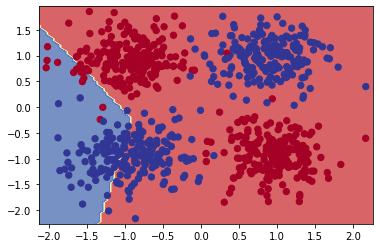

In [59]:
plot_decision_boundary(model, X_train, y_train)

### `forward()`

The `forward()` method applies the neural network to the provided feature vectors.

In [60]:
with torch.inference_mode(): 
    predictions = model(X_test[:10])

predictions = torch.squeeze(predictions).detach().numpy()

predictions

array([-0.0587606 ,  0.11051083, -0.04945789,  0.01304299, -0.21373823,
       -0.9602405 , -0.7919964 , -0.9532247 , -0.26948446, -1.0562019 ],
      dtype=float32)

Now we can compute evaluation metrics from these predicitons, e.g. the AUC.

In [61]:
from sklearn.metrics import roc_auc_score

with torch.inference_mode(): 
    predictions = model(X_test)

predictions = torch.squeeze(predictions).detach().numpy()

print("test set AUC: {}".format(roc_auc_score(y_test,predictions)))

test set AUC: 0.5838383838383838


## Training the model

We use `BCEWithLogitsLoss` as the loss function and SGD, `torch.optim.SGD(params, lr)` as the optimizer.

In [62]:
learning_rate = 0.01

#the loss function
loss_func = torch.nn.BCEWithLogitsLoss()

#the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Now we can create and run our training and validation loop.



0
training loss: 0.7200626134872437
validation AUC: 0.5376602564102564


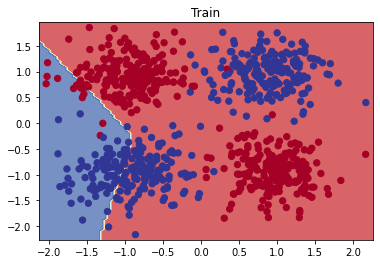

500
training loss: 0.608263373374939
validation AUC: 0.7736378205128205


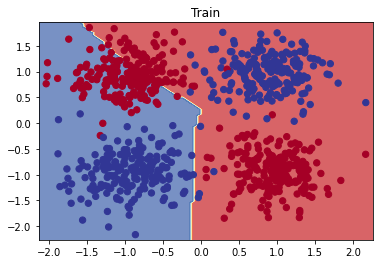

1000
training loss: 0.5165762901306152
validation AUC: 0.8421474358974359


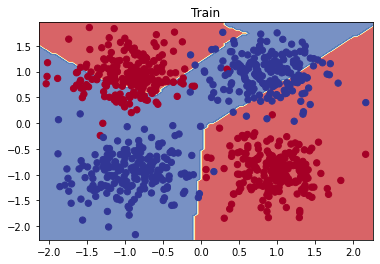

1500
training loss: 0.4204603433609009
validation AUC: 0.8541666666666667


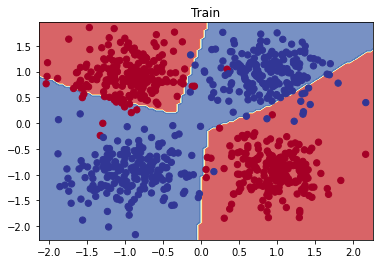

2000
training loss: 0.3105696439743042
validation AUC: 0.9781650641025641


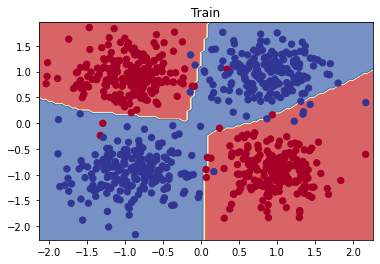

2500
training loss: 0.21763858199119568
validation AUC: 0.9873798076923077


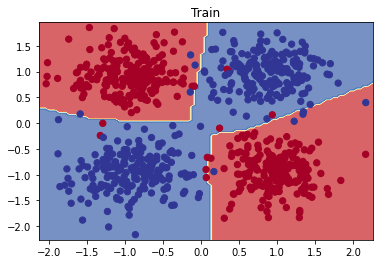

3000
training loss: 0.15847940742969513
validation AUC: 0.9929887820512819


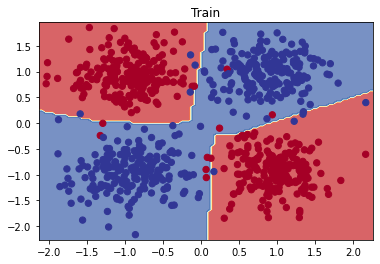

3500
training loss: 0.12390412390232086
validation AUC: 0.9981971153846153


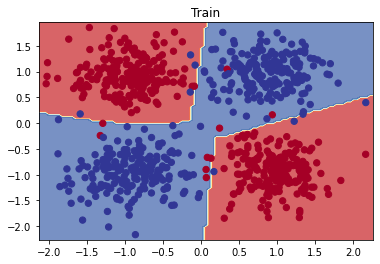

4000
training loss: 0.10239193588495255
validation AUC: 0.9981971153846153


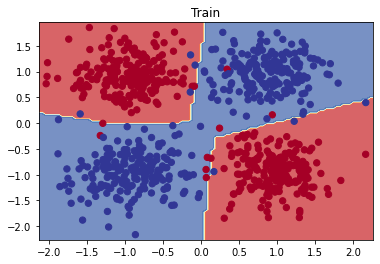

4500
training loss: 0.08854124695062637
validation AUC: 0.9981971153846154


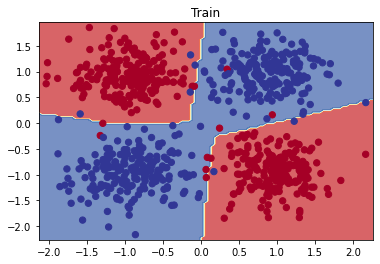

In [63]:
#number of times we iterate trough the train set
num_epochs = 5000

for epoch in range(num_epochs):

    #step 1
    predictions_train = torch.squeeze(model(X_train)) 

    #step 2
    loss = loss_func(predictions_train, y_train) 

    #step 3
    optimizer.zero_grad() 

    #step 4
    loss.backward() 

    #step 5
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
        
    if epoch % 500 == 0:    
      #compute AUC on validation set
      predictions_val = torch.squeeze(model(X_val)).round().detach().numpy()
      #print(predictions_val)
      print(epoch)
      print("training loss: {}".format(loss))    
      print("validation AUC: {}".format(roc_auc_score(y_val,predictions_val)))
      plt.clf()
      plt.title("Train")
      plot_decision_boundary(model, X_train, y_train)
      plt.show()


## Computing predictions and evaluating the model


In [64]:
model.eval()

with torch.inference_mode(): 
    predictions_test = model(X_test)

predictions_test = torch.squeeze(predictions_test).detach().numpy()

print("test set AUC: {}".format(roc_auc_score(y_test,predictions_test)))

test set AUC: 0.9991919191919192
